In [1]:
import os
from scipy.io import loadmat
from scipy.stats import zscore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from lmfit import Model, Parameters

In [3]:
path = '../datasets/dataset1_reaching-task'
fname = os.path.join(path, 'Dataset1.mat')

data = loadmat(fname)
y = data['direction']
x = data['R']
x = np.concatenate((x[:23, :], x[24:, :])) # removing zeros neuron

# reformat y
y_ref = np.zeros(len(y))
for (i, val) in enumerate(y):
    y_ref[i]= val
    
y = y_ref # overwriting

## Day 1

Text(0.5, 0, 'trials')

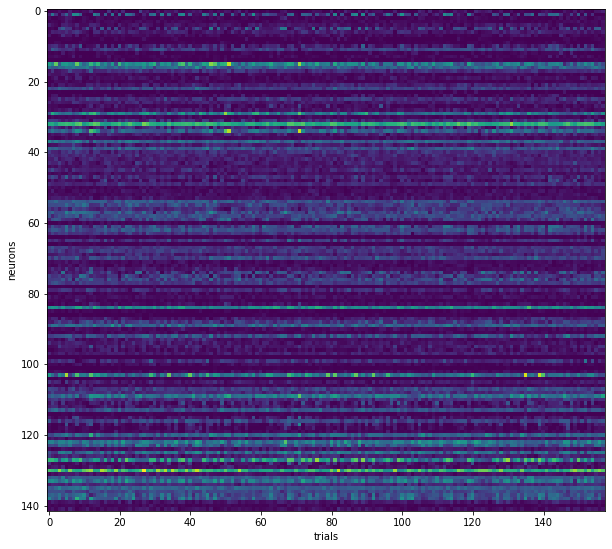

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(x)
plt.ylabel('neurons')
plt.xlabel('trials')

Text(0.5, 0, 'trials')

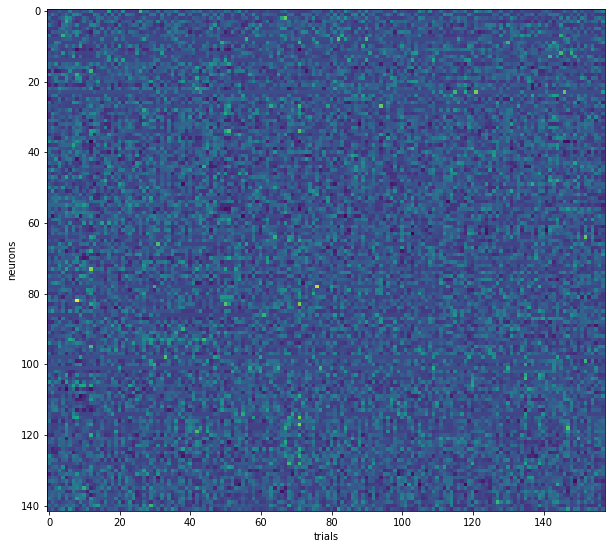

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(zscore(x,1))
plt.ylabel('neurons')
plt.xlabel('trials')

In [6]:
inds_sort = np.argsort(y)
ch_trials = np.where(np.diff(y[inds_sort]) == 1)
x_sorted = x[:,inds_sort]

Text(0.5, 0, 'trials')

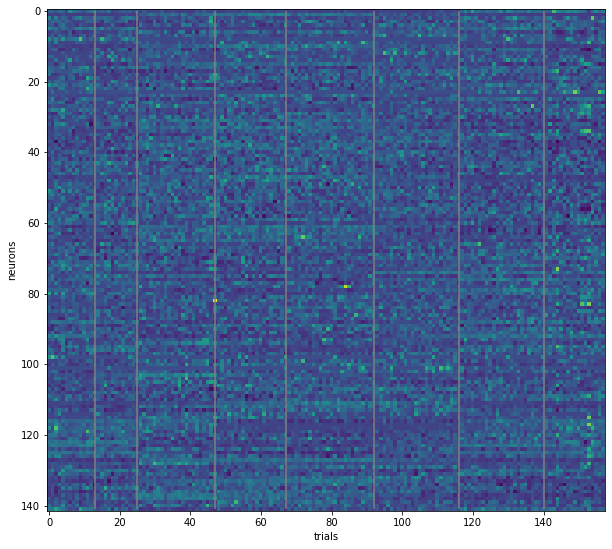

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(zscore(x_sorted,axis=1))
plt.vlines(ch_trials, 0, 141, color='grey')
plt.ylabel('neurons')
plt.xlabel('trials')

In [8]:
#getting condition-averaged population vector

avgs = []
stds = []

for i in range(1, int(max(y))+1):
    dir_avg = np.mean(x[:,y==i], axis=1)
    dir_std = np.std(x[:,y==i], axis=0)
    avgs.append(dir_avg)
    stds.append(dir_std)
    
avgs_array = np.asarray(avgs)
stds_array = np.asarray(avgs)

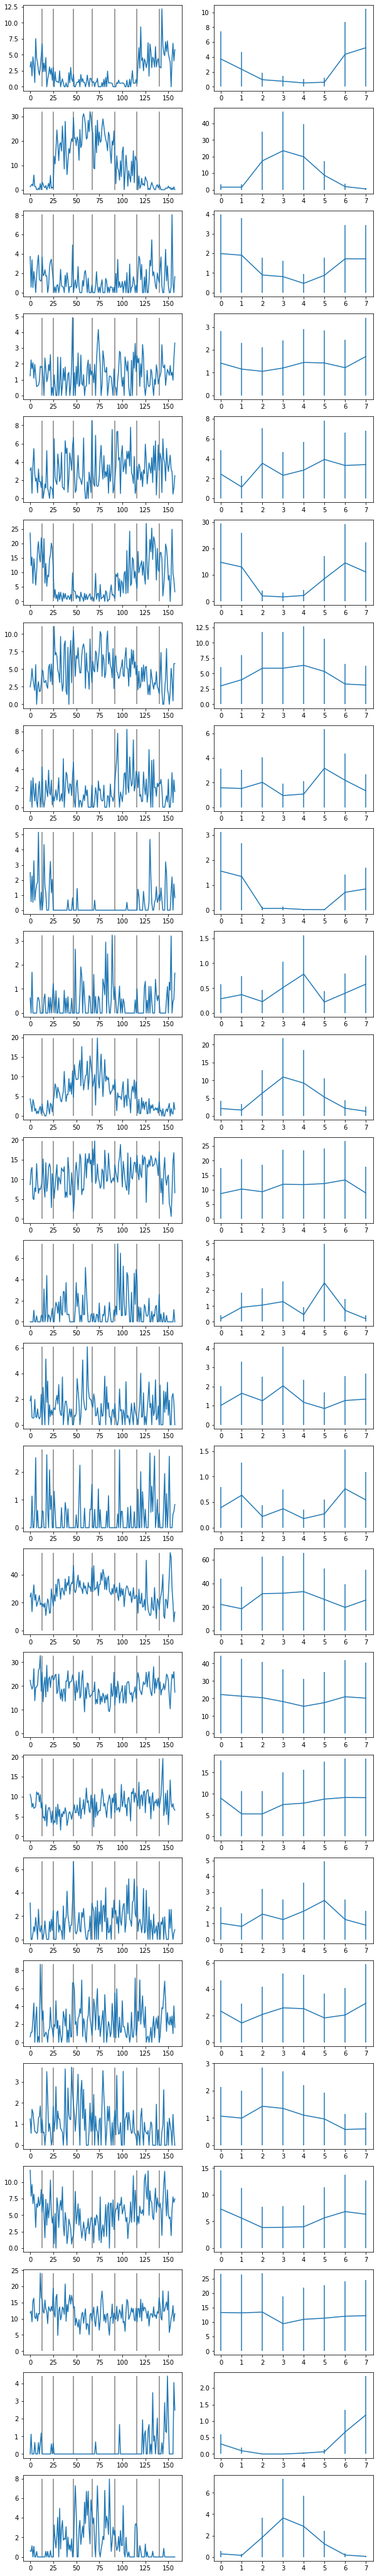

In [9]:
n_plots = 25

_, axs = plt.subplots(n_plots, 2, figsize=(10,n_plots*3))

for i in range(n_plots):
    axs[i,0].vlines(ch_trials, 0, max(x_sorted[i,:]), color='grey')
    axs[i,0].plot(x_sorted[i,:])
    axs[i,1].errorbar(np.arange(0,8), avgs_array.T[i,:], yerr = stds_array[:,i])

In [10]:
# TODO: fit tuning function and then plot distribution of maxima
# TODO: polar plots https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_demo.html

In [11]:
pca = PCA(n_components=10)
pca.fit(x)

PCA(n_components=10)

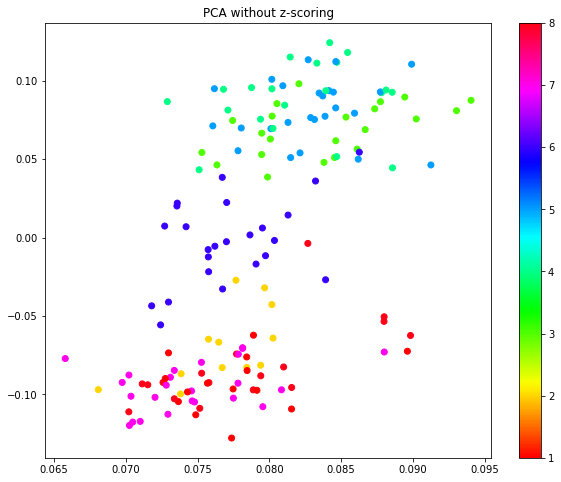

In [12]:
plt.figure(figsize=(10,8))
plt.scatter(pca.components_[0,:], pca.components_[1,:], c=y, cmap='hsv')
plt.title('PCA without z-scoring')
plt.colorbar()

In [13]:
pca = PCA(n_components=10)
pca.fit(zscore(x,1))

PCA(n_components=10)

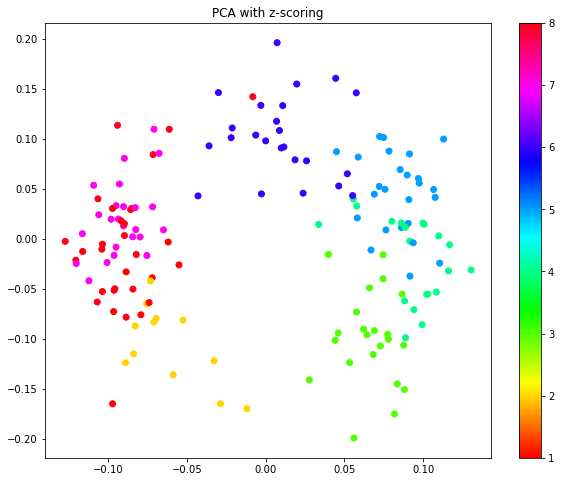

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(pca.components_[0,:], pca.components_[1,:], c=y, cmap='hsv')
plt.title('PCA with z-scoring')
plt.colorbar()

Text(0.5, 0, 'PC index')

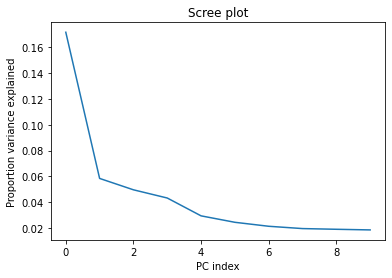

In [15]:
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree plot')
plt.ylabel('Proportion variance explained')
plt.xlabel('PC index')
# think of surrogate distribution for decreasing of the slope of scree plot
# maybe just take one trial type, do PCA and get an estimate for a 'noise distribution'

## Day 2

In [19]:
def tuning_function(x, mu, kappa, fmax, bsl):
    # Von Mises, with kappa the concentration, mu the location
    # fmax the firing rate at pref ori, bsl the min firing rate (not the baseline, which was substracted) 
    tf = bsl + np.exp(kappa*np.cos((x-mu))) * (fmax - bsl)
    return tf

def fit_tc(array, init_kappa):
    x = np.linspace(0, 2*np.pi, len(array), endpoint=False)

    mod = Model(tuning_function)
    pars = Parameters()
    pars.add_many(('mu', x[np.argmax(array)], True, 0., 2*np.pi),
                  ('kappa', init_kappa, True,  0.1, 5.),
                  ('fmax', np.max(array), True, 0.0, 2*np.max(array)+5),
                 ('bsl', np.min(array), True, 0.0, np.max(array)+5))
    out = mod.fit(array, pars, x=x, nan_policy='omit', max_nfev = 50000)
    
    return out.best_values

In [20]:
# fitting von Mises function
mus = []
kappas = []
fmaxs = []
bsls = []

for i in range(avgs_array.shape[1]):
#for i in range(5):
    out = fit_tc(avgs_array[:,i], 1)
    mus.append(out['mu'])
    kappas.append(out['kappa'])
    fmaxs.append(out['fmax'])
    bsls.append(out['bsl'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

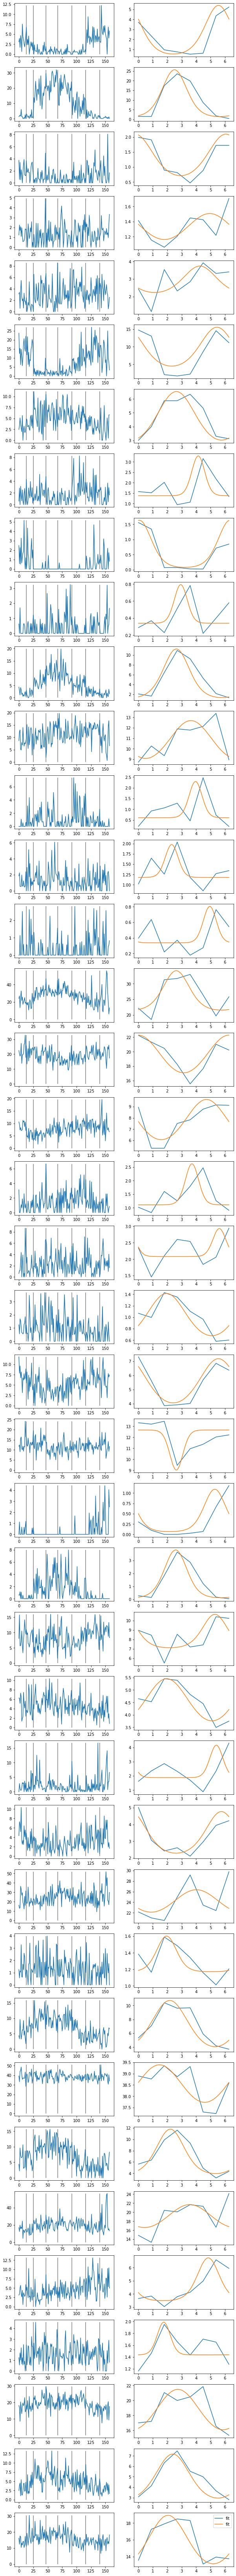

In [57]:
# plotting results
n_plots = 40

_, axs = plt.subplots(n_plots, 2, figsize=(10,n_plots*3))

for i in range(n_plots):
    axs[i,0].vlines(ch_trials, 0, max(x_sorted[i,:]), color='grey')
    axs[i,0].plot(x_sorted[i,:])
#    axs[i,1].errorbar(np.arange(0,8), avgs_array.T[i,:], yerr = stds_array[:,i])

    x_data = np.linspace(0, 2*np.pi, len(avgs_array.T[i,:]))
    axs[i,1].plot(x_data, avgs_array.T[i,:])
    
    x_fit = np.linspace(0, 2*np.pi, 1000)
    axs[i,1].plot(x_fit, tuning_function(x_fit, mus[i], kappas[i], fmaxs[i], bsls[i]))    


Text(0.5, 0, 'preferred angle')

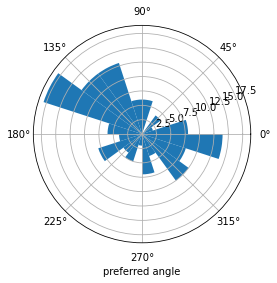

In [55]:
ax = plt.subplot(111, polar=True)
plt.hist(np.array(mus),20)
plt.xlabel('preferred angle')